**Pneumonia type classification using Loss Calibration for BNN approach**

We are going to focus on three classes of images:

1. Normal: not pneumonia
2. Bacterial Pneumonia
3. Viral Pneumonia: not covid-19
4. Covid-19

We want to maximize the capacity of the model to predict correctly the covid-19 cases from images and avoid false negatives mostly for this class. Then we are going to proposse a utility function based on the paper idea in order to obtain good results for this task.

In [48]:
import os
import numpy
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
#paths
data = './data/'
covid_path = data + 'COVID-19/'
x_ray_path = data + 'chest_xray/'

In [12]:
IMG_SIZE = 28

In [16]:
def read_images(images_paths):
    images = []
    for image_path in images_paths:
        image = cv2.imread(image_path)
        # resize image
        image = cv2.resize(image,(IMG_SIZE,IMG_SIZE))
        # transform to grayscale
        image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
        images.append(image)
    # reshape images to 1D array
    images = np.array(images).reshape(-1,IMG_SIZE*IMG_SIZE)
    return images

In [25]:
X_train = np.array([])
y_train = np.array([])
X_test = np.array([])
y_test = np.array([])

In [17]:
# read covid images
covid_images_paths = [covid_path + file_name for file_name in os.listdir(covid_path)]
covid_images = read_images(covid_images_paths)

In [23]:
covid_train, covid_test = train_test_split(covid_images, test_size=0.2, random_state=42)
len(covid_train), len(covid_test)

(156, 40)

In [28]:
covid_test.shape

(40, 784)

In [34]:
# add covid images to train and test
X_train = covid_train
y_train = np.ones(len(covid_train))*3
X_test = covid_test
y_test = np.ones(len(covid_test))*3

In [35]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((156, 784), (156,), (40, 784), (40,))

In [37]:
# read normal images
normal_train_paths = [x_ray_path + 'train/NORMAL/' + file_name for file_name in os.listdir(x_ray_path + 'train/NORMAL/')]
normal_train = read_images(normal_train_paths)
normal_test_paths = [x_ray_path + 'test/NORMAL/' + file_name for file_name in os.listdir(x_ray_path + 'test/NORMAL/')]
normal_test = read_images(normal_test_paths)

In [38]:
# add normal images to train and test
X_train = np.concatenate((X_train, normal_train))
y_train = np.concatenate((y_train, np.zeros(len(normal_train))))
X_test = np.concatenate((X_test, normal_test))
y_test = np.concatenate((y_test, np.zeros(len(normal_test))))

In [39]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1505, 784), (1505,), (274, 784), (274,))

In [40]:
# read pneumonia images
pneumonia_train_paths = [x_ray_path + 'train/PNEUMONIA/' + file_name for file_name in os.listdir(x_ray_path + 'train/PNEUMONIA/')]
pneumonia_train = read_images(pneumonia_train_paths)
pneumonia_test_paths = [x_ray_path + 'test/PNEUMONIA/' + file_name for file_name in os.listdir(x_ray_path + 'test/PNEUMONIA/')]
pneumonia_test = read_images(pneumonia_test_paths)

In [41]:
# get labels for bacterial and viral pneumonia
pneumonia_train_labels = [1 if 'bacteria' in file_name else 2 for file_name in pneumonia_train_paths]
pneumonia_test_labels = [1 if 'bacteria' in file_name else 2 for file_name in pneumonia_test_paths]

In [42]:
# add pneumonia images to train and test
X_train = np.concatenate((X_train, pneumonia_train))
y_train = np.concatenate((y_train, pneumonia_train_labels))
X_test = np.concatenate((X_test, pneumonia_test))
y_test = np.concatenate((y_test, pneumonia_test_labels))

In [43]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5388, 784), (5388,), (664, 784), (664,))

In [44]:
# shuffle data
np.random.seed(42)
permutation = np.random.permutation(X_train.shape[0])
X_train = X_train[permutation]
y_train = y_train[permutation]

permutation = np.random.permutation(X_test.shape[0])
X_test = X_test[permutation]
y_test = y_test[permutation]

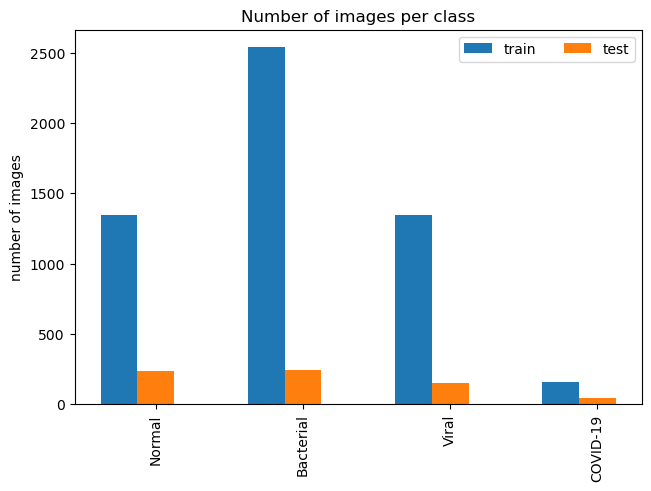

In [49]:
# plot the distribution of the classes on train and test
x = np.arange(4)  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for l in ['train', 'test']:
    offset = width * multiplier
    v = [np.sum(y_train == i) if l == 'train' else np.sum(y_test == i) for i in range(4)]
    rects = ax.bar(x + offset, v, width, label=l)
    multiplier += 1

ax.set_ylabel('number of images')
ax.set_title('Number of images per class')
ax.set_xticks(x + width, ['Normal', 'Bacterial', 'Viral', 'COVID-19'])
ax.legend(loc='upper right', ncols=2)

plt.xticks(rotation=90)

plt.show()


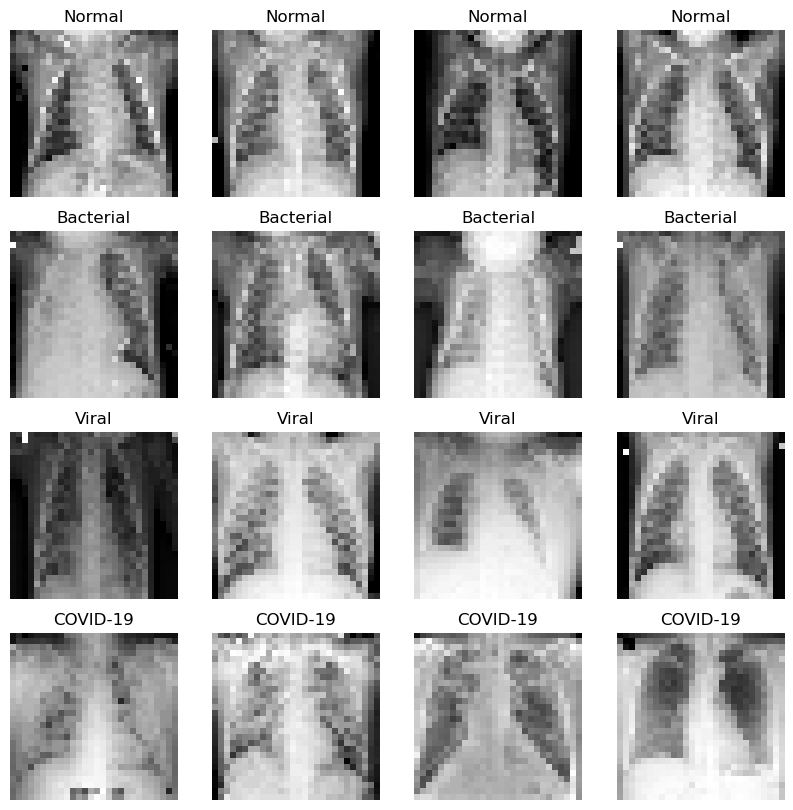

In [50]:
# visualize some images for each class
classes = ['Normal', 'Bacterial', 'Viral', 'COVID-19']
fig, ax = plt.subplots(4, 4, figsize=(10, 10))
for i in range(4):
    for j in range(4):
        ax[i, j].imshow(X_train[y_train == i][j].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
        ax[i, j].set_title(classes[i])
        ax[i, j].axis('off')
plt.show()

In [57]:
# define the utility function for the problem
U = np.eye(4)
U[0,1] = 0.2 # pred = normal, true = bacterial
U[0,2] = 0.1 # pred = normal, true = viral
U[0,3] = 0.0 # pred = normal, true = covid
U[1,0] = 0.5 # pred = bacterial, true = normal
U[1,2] = 0.2 # pred = bacterial, true = viral
U[1,3] = 0.1 # pred = bacterial, true = covid
U[2,0] = 0.4 # pred = viral, true = normal
U[2,1] = 0.2 # pred = viral, true = bacterial
U[2,3] = 0.2 # pred = viral, true = covid
U[3,0] = 0.4 # pred = covid, true = normal
U[3,1] = 0.4 # pred = covid, true = bacterial
U[3,2] = 0.5 # pred = covid, true = viral
U


array([[1. , 0.2, 0.1, 0. ],
       [0.5, 1. , 0.2, 0.1],
       [0.4, 0.2, 1. , 0.2],
       [0.4, 0.4, 0.5, 1. ]])